# Autoencoders 

Autoencoders are neural networks that learn low-dimensional latent representations from which the original data can be reconstructed as well as possible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
scaler = StandardScaler().set_output(transform="default")
data = scaler.fit_transform(data_original)

In [ ]:
# For Colab
#import os
#os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras

In [4]:
# for debugging
keras.config.disable_traceback_filtering()

We will apply an autoencoder approach to reduce the dimensionality of the tomato gene expression dataset. For computational efficiency, we will use here only the first 500 genes, so the following call reduces 500-dimensional profiles to two-dimensional profiles.

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9072
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9060
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9053
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9042
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9026
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8999
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8961
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8909
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8841
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8755
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8650
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8530
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8399
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8270
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8152
Epoch 16/200
1/1 ━━

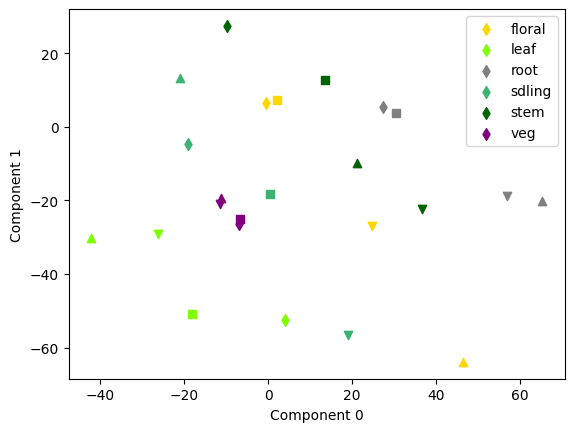

In [5]:
# Simple autoencoder without regularization
tissue_dict = {'floral': 'gold', 'leaf': 'chartreuse', 'root': 'gray', 'sdling': 'mediumseagreen', 'stem': 'darkgreen', 'veg': 'purple'}
species_condition_dict = {'penn.Sun': 's', 'penn.Sh': 'd', 'M82.Sun': '^', 'M82.Sh': 'v'}
def plot_components(data_transformed, j=0, k=1, tissuelegend=True, legendloc="upper right"):
    for i in range(0,data_transformed.shape[0]):
        plt.scatter(data_transformed[i,j], data_transformed[i,k], marker=species_condition_dict['.'.join([data_with_labels.iloc[i]['species'], data_with_labels.iloc[i]['position']])], c=tissue_dict[data_with_labels.iloc[i]['tissue']])
    plt.xlabel("Component {}".format(j)) 
    plt.ylabel("Component {}".format(k))
    if tissuelegend:
        plt.legend(tissue_dict, loc=legendloc)
    else:
        def make_markers(ind):
            return(plt.Line2D([], [], color='black', marker=list(species_condition_dict.values())[ind], linestyle='None'))
        plt.legend([make_markers(l) for l in range(0,len(species_condition_dict.values()))], species_condition_dict.keys(), loc=legendloc)
    plt.show()


def autoencoder(X, n_components=2):  
    keras.utils.set_random_seed(42) 
    #seed_generator = keras.random.SeedGenerator(42)
        
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.random.normal(shape=(n_components,), seed=42) # seed=seed_generator
        return z_mean + keras.ops.exp(z_log_var) * epsilon

    layer_sizes = [128,64,32,16]
    #encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z_mean = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    z_log_var = Dense(n_components, kernel_initializer='glorot_normal', name='latent_sigma')(x)

    z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    #decoder
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
        
    
    
    vae = Model(inputs, decoder(encoder(inputs)[2]), name='vae')

    vae.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), run_eagerly=False) 
    vae.fit(x=X,y=X, epochs=200, verbose=1, batch_size=24)
    
    Y_VAE = encoder.predict(X)[0]
    
    plot_components(Y_VAE)

autoencoder(data[:,range(500)])


Next, we will try a variational autoencoder. This is an autoencoder that uses regularization during training to ensure that the latent space has certain properties. For that purpose, the loss function is composed of a reconstruction term (for the final layer) and a regularization term (for the latent layer).

In [7]:
# Variational autoencoder
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")

    def train_step(self, x):
        
        self.zero_grad()
        
        z_mean, z_log_var, z = self.encoder(x)
        x_decoded_mean = self.decoder(z)
   
        reconstruction_loss = keras.ops.mean(keras.ops.square(x-x_decoded_mean))
        
        kl_loss = - 0.5 * (1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var))
        
        kl_loss = keras.ops.mean(keras.ops.sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        total_loss.backward()

        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]
        self.optimizer.apply(gradients, trainable_weights)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    def call(self, inputs, *args, **kwargs):
        return self.decoder(self.encoder(inputs)[2])
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker]

def variational_autoencoder(X, n_components=2):  
    keras.utils.set_random_seed(42) 
    #seed_generator = keras.random.SeedGenerator(42)
        
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.random.normal(shape=(n_components,), seed=42) # seed=seed_generator
        return z_mean + keras.ops.exp(z_log_var) * epsilon

    layer_sizes = [128,64,32,16]
    
    #encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z_mean = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    z_log_var = Dense(n_components, kernel_initializer='glorot_normal', name='latent_sigma')(x)

    z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    #decoder
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    
    decoder = Model(latent_inputs, outputs, name='decoder')
        
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(x=X, epochs=200, verbose=1, batch_size=24)
    
    Y_VAE = encoder.predict(X)[0]
    
    plot_components(Y_VAE)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3493 - reconstruction_loss: 0.9072
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4159 - reconstruction_loss: 0.9062
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1384 - reconstruction_loss: 0.9061
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0401 - reconstruction_loss: 0.9061
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9957 - reconstruction_loss: 0.9060
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9678 - reconstruction_loss: 0.9060
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9513 - reconstruction_loss: 0.9059
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9406 - reconstruction_loss: 0.9059
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9348 - reconstruction_loss: 0.9058
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9302 - reconstruction_loss: 0.9058
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

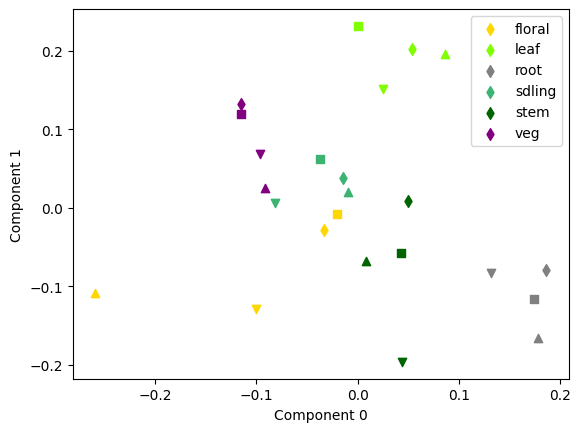

In [8]:
variational_autoencoder(data[:,range(500)]) 

### Task:
1. What is the rationale behind using regularization? What can happen without regularization?
2. What is a potential drawback of regularization? What can happen if regularization is too strong? You can play with the weight of the regularization term.